In [8]:
import numpy as np
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork
import tf_agents.networks.network as network
from tf_agents.specs import tensor_spec
from snake_game import SnakeGame
from scene import Scene
from scene_longer_snake import SceneLongerSnake
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, AveragePooling2D

MAP_WIDTH = MAP_HEIGHT = 10
BLOCK_SIZE = 15

scene = SceneLongerSnake(
    init_randomly=True,
    map_width=MAP_WIDTH,
    map_height=MAP_HEIGHT,
    block_size=BLOCK_SIZE,
    snake_longer_prob=0.95,
    length_mean=16,
    length_std=3
)
episodes_count = 40000
random_episodes = 15000


In [9]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

env = SnakeGame(scene)
env = TFPyEnvironment(env)


In [10]:
class MyQNetwork(network.Network):
    def __init__(self,
                 input_tensor_spec,
                 action_spec,
                 name='MyQNetwork'):
        super(MyQNetwork, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=(),
            name=name)
        
        self._action_spec = action_spec
        matrix_shape = input_tensor_spec.shape
        # obstacles_shape = input_tensor_spec[1].shape
        # no_body_blocks_shape = input_tensor_spec[2].shape
        # relative_food_direction_shape = input_tensor_spec[3].shape
        
        input0 = Input(shape=matrix_shape)
        # input1 = Input(shape=obstacles_shape) # Each value represents if there is a wall or the snake body in the direction, 0 - no wall, 1 - wall
        # input2 = Input(shape=no_body_blocks_shape) # Each value represents how many no body blocks are in the direction
        # input3 = Input(shape=relative_food_direction_shape)
        
        conv1 = Conv2D(32, (2, 2), 1, padding="same", activation='relu', kernel_initializer='he_normal')(input0)
        maxpool1 = AveragePooling2D((2, 2))(conv1)
        flat = Flatten()(maxpool1)
        dense1 = Dense(128, activation='relu', kernel_initializer='he_normal')(flat)
        dense2 = Dense(64, activation='relu', kernel_initializer='he_normal')(dense1)
        
        # concat = tf.keras.layers.concatenate([dense3, input1, input2, input3])
        # output = Dense(4, activation='linear')(concat)
        output = Dense(4, activation='linear')(dense2)
        
        # self._model = tf.keras.Model(inputs=[input0, input1, input2, input3], outputs=output)
        self._model = tf.keras.Model(inputs=[input0], outputs=output)
        
        self._model.summary()

    def call(self, observations, step_type=None, network_state=(), training=False):
        # output = self._model([observations[0], observations[1], observations[2], observations[3]])
        output = self._model([observations])
        return output, network_state

q_net = MyQNetwork(
    env.observation_spec(),
    env.action_spec())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 10, 4)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        544       
                                                                 
 average_pooling2d_2 (Avera  (None, 5, 5, 32)          0         
 gePooling2D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               102528    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                           

In [11]:
# Create the agent
from tf_agents.agents.dqn.dqn_agent import DdqnAgent
from tensorflow import keras
from keras.optimizers.legacy import Adam
from keras.losses import Huber
from tf_agents.trajectories import TimeStep

train_step_counter = tf.Variable(0)
optimizer = Adam(learning_rate=0.002)

# epsilon = keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate=0.05,
#     decay_steps=episodes_count,
#     end_learning_rate=0.002
# )

agent = DdqnAgent(
    time_step_spec=env.time_step_spec(),
    action_spec=env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=Huber(reduction="none"),
    gamma=tf.constant(0.99, dtype=tf.float32),
    train_step_counter=train_step_counter,
    epsilon_greedy=lambda: 0#epsilon(train_step_counter)
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 10, 4)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        544       
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 32)          0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               102528    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                           

In [12]:
# Create the replay buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=100000
)


In [13]:
# Create the training metrics
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]


In [14]:
# Create the driver
from tf_agents.drivers import dynamic_step_driver

collect_driver = dynamic_step_driver.DynamicStepDriver(
    env,
    policy=agent.collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_steps=2
)

# Run a random policy to fill the replay buffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(env.time_step_spec(), env.action_spec())
init_driver = dynamic_step_driver.DynamicStepDriver(
    env,
    policy=initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=random_episodes
)

final_time_step, final_policy_state = init_driver.run()


In [15]:
# Create the dataset
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2, # Capaz cambiar esto
    num_parallel_calls=5
).prefetch(5)


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [16]:
# Create the training loop

from tf_agents.utils.common import function
from tf_agents.trajectories import trajectory
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        if iteration % 1000 == 0:
            print("Iteration: ", iteration)
            print("Replay buffer len: " + str(replay_buffer.num_frames().numpy()))
            log_metrics(train_metrics)


In [17]:
train_agent(episodes_count)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


INFO:absl: 
		 NumberOfEpisodes = 3
		 EnvironmentSteps = 2
		 AverageReturn = -80.0
		 AverageEpisodeLength = 0.3333333432674408


Iteration:  0
Replay buffer len: 2656


INFO:absl: 
		 NumberOfEpisodes = 181
		 EnvironmentSteps = 2002
		 AverageReturn = -6944.0
		 AverageEpisodeLength = 20.0


Iteration:  1000
Replay buffer len: 4834


INFO:absl: 
		 NumberOfEpisodes = 283
		 EnvironmentSteps = 4002
		 AverageReturn = -10902.0
		 AverageEpisodeLength = 23.799999237060547


Iteration:  2000
Replay buffer len: 6936


INFO:absl: 
		 NumberOfEpisodes = 331
		 EnvironmentSteps = 6002
		 AverageReturn = -12712.0
		 AverageEpisodeLength = 44.70000076293945


Iteration:  3000
Replay buffer len: 8984


In [20]:
# # Evaluate the agent

test_scene = Scene(init_randomly=True)
test_env = SnakeGame(test_scene)
test_env = TFPyEnvironment(test_env)

# time_step = test_env.reset()
# rewards = []
# steps = 0

# while not time_step.is_last() and steps < 2000:
#     steps += 1
#     print("Map:\n", np.argmax(time_step.observation, axis=3))
#     print("Direction:\n", time_step.observation[1])
#     print("No body blocks:\n", time_step.observation[2])
#     action_step = agent.policy.action(time_step)
#     print("Action: ", action_step.action.numpy())
#     time_step = test_env.step(action_step.action)
#     rewards.append(time_step.reward.numpy()[0])
    
# print("Total reward: ", sum(rewards))
# print("Total steps: ", steps)


In [21]:

# Count the average steps per episode

n = 100
total_steps = 0
total_reward = 0
steps = 0
max_steps = 2000
total_max_steps = 0

for i in range(n):
    if i % 10 == 0 and i != 0:
        print("Episode: ", i)
        
    time_step = test_env.reset()
    steps = 0
    episode_reward = 0
    while not time_step.is_last() and steps < max_steps:
        steps += 1
        action_step = agent.policy.action(time_step)
        time_step = test_env.step(action_step.action)
        reward = time_step.reward.numpy()[0]
        total_reward += reward
        episode_reward += reward
        
    if steps == max_steps:
        total_max_steps += 1
    else:
        total_steps += steps
        
    if i % 10 == 0 and i != 0:
        print("Avg reward: ", total_reward / (i + 1))
        
print("Average steps per episode: ", total_steps / (n - total_max_steps))
print("Average reward per episode: ", total_reward / n)
print("Total max steps episodes: ", total_max_steps)


Episode:  10
Avg reward:  -36.81818181818182


KeyboardInterrupt: 

In [ ]:
# Save the q network weights
tf.keras.models.save_model(q_net._model, "q_network_10x10.h5")

/var/folders/bw/_7s8wxw93cngpt5f7bg5s3hm0000gn/T/ipykernel_35888/4294134740.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(q_net._model, "q_network_10x10.h5")


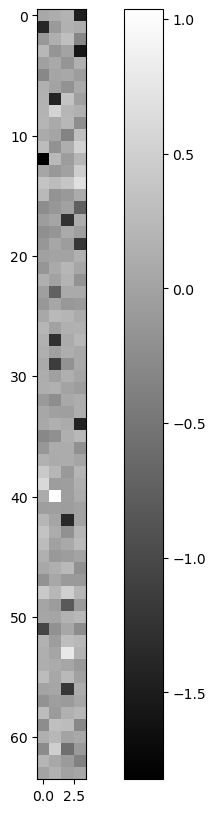

In [ ]:
layer_weights = q_net._model.weights[-2].numpy()

# Plot the weights. In the y axis are the 4 actions, in the x axis are the 28 neurons of the last dense layer
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(layer_weights, cmap='gray')
plt.colorbar()
plt.show()